In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import xarray as xr
import pytensor.tensor as at
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


sys.path.append('../../')
from util.preprocessing_utils import standardize_column
from util.dataframe_utils import analyse_columns

In [2]:
df = pd.read_csv('../../data/processed/ProcessedTweets.csv')

In [3]:
# to keep things clean, let's first drop all the columns that we won't be using

df = df.drop(['tweet_id', 'negative_reason', 'negative_reason_confidence', 
              'name', 'retweet_count', 'text', 'tweet_created', 'tweet_location',
              'user_timezone',], axis=1)
df.head()

,airline_sentiment,airline_sentiment_confidence,airline,fractional_hour,hour_sin,hour_cos
0,0,1.0000,0,11.597778,0.105107,-0.994461
1,1,0.3486,0,11.266389,0.190880,-0.981613
2,0,0.6837,0,11.263333,0.191666,-0.981460
3,2,1.0000,0,11.260000,0.192522,-0.981293
4,2,1.0000,0,11.245833,0.196160,-0.980572


Standardize `airline_sentiment` and `airline_sentiment_confidence`, I am cautious of standardising `hour_sin` and `hour_cos` as they represent the cyclical nature of the hours in a day. However, I actually want to re-encode `airline_sentiment` first to better reflect the underlying nature of the data. The curent encoding schema is:

- Categorical encoding:
    {0: 'neutral', 
    1: 'positive', 
    2: 'negative'}

But I'd prefer if it ranges from `negative` to `neutral` to `positive` so that it reflects a range, with the `negative` category being on the lower end, where it might potentially standardise to a negative value.

In [4]:
sentiment_encoding = {2: -1, 0: 0, 1: 1}
df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_encoding)
df.head()

,airline_sentiment,airline_sentiment_confidence,airline,fractional_hour,hour_sin,hour_cos
0,0,1.0000,0,11.597778,0.105107,-0.994461
1,1,0.3486,0,11.266389,0.190880,-0.981613
2,0,0.6837,0,11.263333,0.191666,-0.981460
3,-1,1.0000,0,11.260000,0.192522,-0.981293
4,-1,1.0000,0,11.245833,0.196160,-0.980572


In [5]:
df = standardize_column(df, 'airline_sentiment')
df = standardize_column(df, 'airline_sentiment_confidence')
df.head()

,airline_sentiment,airline_sentiment_confidence,airline,fractional_hour,hour_sin,hour_cos
0,0.615679,0.613101,0,11.597778,0.105107,-0.994461
1,1.938283,-3.387392,0,11.266389,0.190880,-0.981613
2,0.615679,-1.329417,0,11.263333,0.191666,-0.981460
3,-0.706925,0.613101,0,11.260000,0.192522,-0.981293
4,-0.706925,0.613101,0,11.245833,0.196160,-0.980572


Splitting in to a 80/20 ratio for training and testing, a common ratio in machine learning.

In [6]:
X = df.drop('airline_sentiment', axis=1)
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
with pm.Model() as model:
    alpha = pm.Normal('Intercept', mu=0, sigma=10)
    airline_coeff = pm.Normal('airline_coeff', mu=0, sigma=10, shape=len(X_train['airline'].unique()))
    conf_coeff = pm.Normal('conf_coeff', mu=0, sigma=10)
    sine_coeff = pm.Normal('sine_coeff', mu=0, sigma=10)
    cosine_coeff = pm.Normal('cosine_coeff', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    airline_index = X_train['airline'].astype(int)

    mu = (alpha + 
          airline_coeff[airline_index] +
          conf_coeff * X_train['airline_sentiment_confidence'] +
          sine_coeff * X_train['hour_sin'] +
          cosine_coeff * X_train['hour_cos']
    )

    sentiment_obs = pm.Normal('sentiment_obs', mu=mu, sigma=sigma, observed=y_train)

    nuts_sampler_kwargs = {'target_accept': 0.99, 'max_treedepth': 20}
    trace = pm.sample(2000, tune=1000, nuts_sampler_kwargs=nuts_sampler_kwargs, return_inferencedata=True)

az.summary(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, airline_coeff, conf_coeff, sine_coeff, cosine_coeff, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1143 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.157,3.619,-6.630,6.989,0.125,0.088,844.0,1429.0,1.0
airline_coeff[0],0.326,3.620,-6.405,7.220,0.124,0.088,845.0,1432.0,1.0
airline_coeff[1],-0.303,3.619,-7.104,6.517,0.125,0.088,844.0,1432.0,1.0
airline_coeff[2],0.097,3.619,-6.706,6.906,0.125,0.088,844.0,1431.0,1.0
airline_coeff[3],0.162,3.619,-6.667,6.966,0.125,0.088,843.0,1421.0,1.0
airline_coeff[4],-0.435,3.619,-7.275,6.352,0.125,0.088,844.0,1434.0,1.0
airline_coeff[5],-0.326,3.619,-7.064,6.559,0.125,0.088,844.0,1429.0,1.0
conf_coeff,-0.180,0.009,-0.197,-0.164,0.000,0.000,6316.0,4044.0,1.0
sine_coeff,0.013,0.012,-0.009,0.036,0.000,0.000,4722.0,4275.0,1.0
cosine_coeff,-0.041,0.014,-0.067,-0.014,0.000,0.000,5239.0,4421.0,1.0


The package recommended that I still increase either `target_accept` or `max_treedepth`, but increasing the maximum tree depth eventually lead to a higher r hat value.

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'airline_coeff'}>,
        <Axes: title={'center': 'airline_coeff'}>],
       [<Axes: title={'center': 'conf_coeff'}>,
        <Axes: title={'center': 'conf_coeff'}>],
       [<Axes: title={'center': 'sine_coeff'}>,
        <Axes: title={'center': 'sine_coeff'}>],
       [<Axes: title={'center': 'cosine_coeff'}>,
        <Axes: title={'center': 'cosine_coeff'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

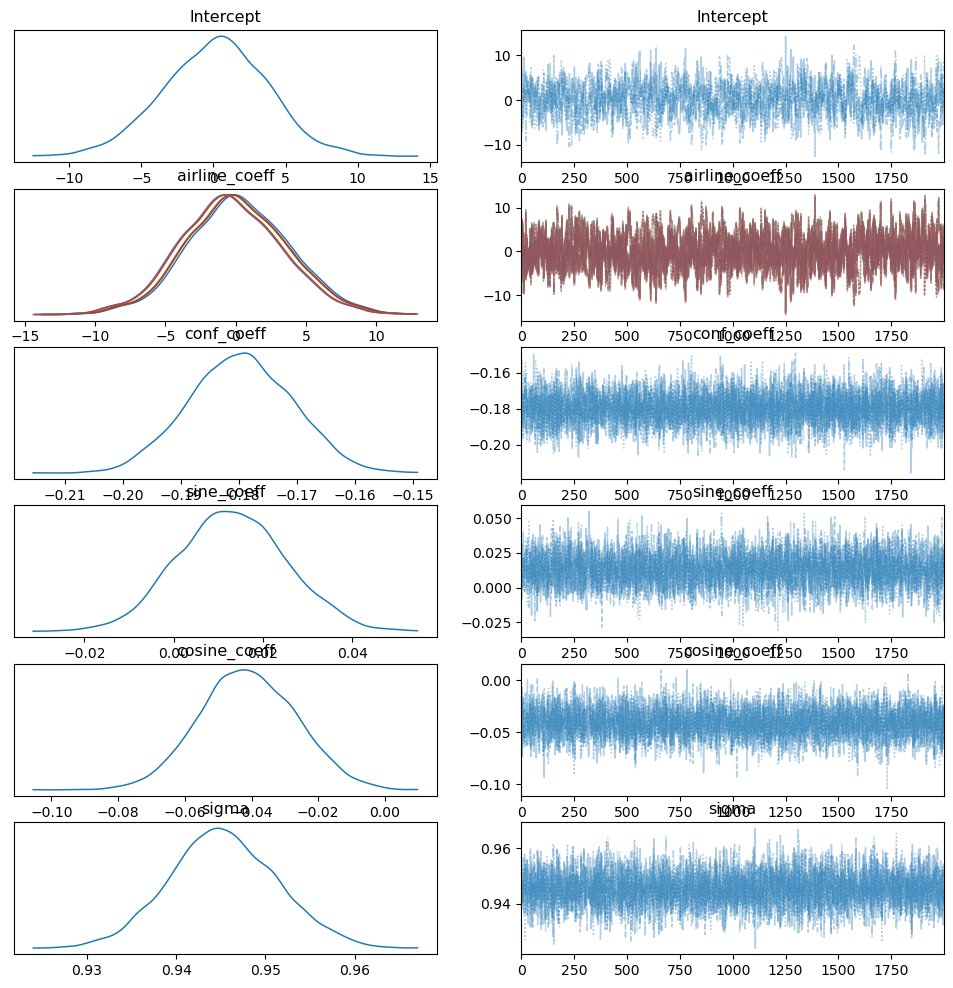

In [8]:
az.plot_trace(trace, combined=True)